# What's the point of this notebook?
At a high level, these are some basic experiments around prompt engineering with CLIP. I chose clip as looking at pretty images makes it a bit more fun (for me at least)

Starting with categorising images as this feels like a simple place to get my head around what's going on.

Then moving to image retrieval as this allows for some more interesting prompt engineering problems

In [1]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

In [2]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

2024-05-31 22:14:11.026585: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 22:14:11.777397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 22:14:13.452542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Classification tasks

In [3]:
def show_results(image, true_label, results, classes):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image[0])
    ax1.tick_params(
        axis='x',  
        which='both',   
        bottom=False, 
        top=False,    
        labelbottom=False
    )
    ax1.tick_params(
        axis='y',  
        which='both',   
        bottom=False, 
        top=False,    
        labelbottom=False
    )
    ax2.bar([x for x in range(len(classes))], results[0], tick_label=classes)
    ax2.tick_params(axis="x", labelrotation=270)
    fig.suptitle(f"Predictions for true label {true_label[0]} with classes {classes}")
    plt.show()

In [4]:
def make_preds(img, classes):
    inputs = processor(text=classes, images=img, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    similarity = outputs.logits_per_image.detach()
    return similarity

In [5]:
class ImageClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.img_nms = os.listdir(self.data_path)

    def __getitem__(self, i):
        name = self.img_nms[i]
        label = name.split("_")[0]
        path = f"{self.data_path}/{name}"
        image = Image.open(path).convert("RGB")
        pix = np.array(image)
        # do we want to do any resizing?
        return pix, label

    def __len__(self):
        return len(self.img_nms)

## Cat vs dog

Based on the data present, add additional classes to see if we can confuse the model:
* Golden retriever
* Pommeranian
* Short hair
* Domestic short hair
* Siamese
* Siamese cat
* Toy
* Soft
* Cuddle
* Grass
* Lie down
    * Lie
    * Down
* Hold
* Held

In [6]:
categories = ["cat", "dog"]

confusing_categories = [
    "short hair",
    "siamese",
    "toy",
    "soft",
    "cuddle",
    "lie down",
    "lie",
    "down",
    "hold",
    "grass",
]

specific_categories = [
    "golden retriever",
    "pommeranian",
    "siamese cat",
    "domestic short hair",
]

In [7]:
dataset = ImageClassificationDataset("./data/cat_dog")
loader = torch.utils.data.DataLoader(dataset)

### Plot results by category - a bit messy but works

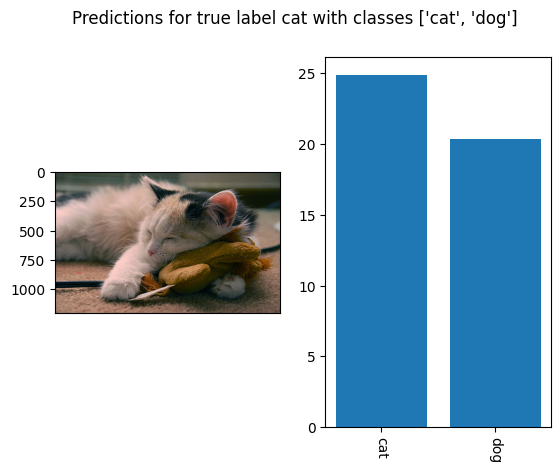

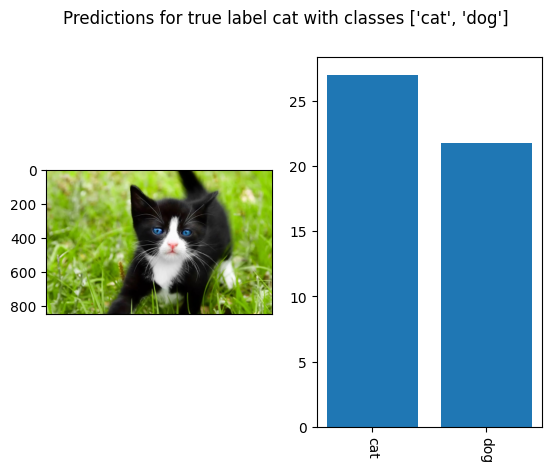

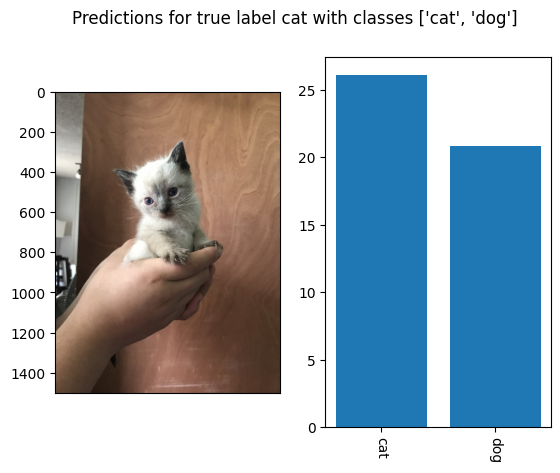

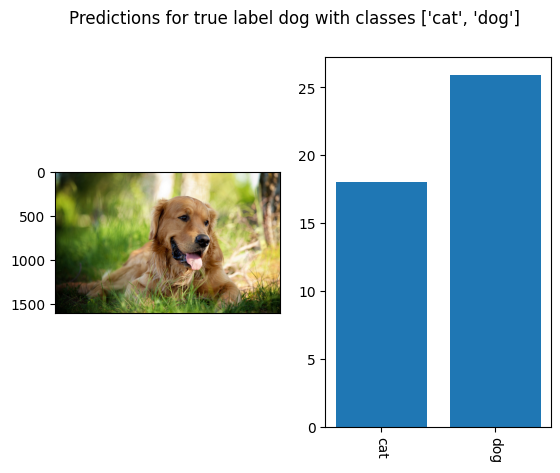

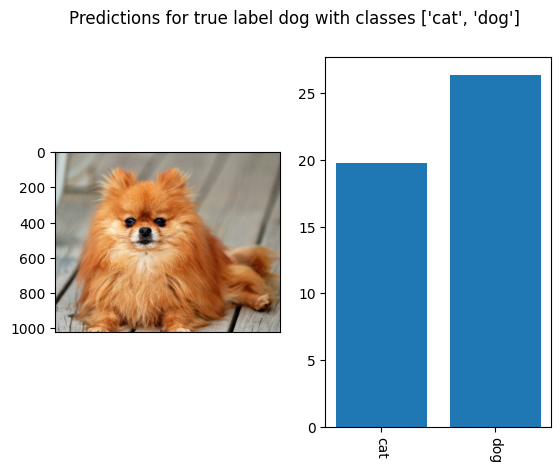

In [8]:
for item in loader:
    img, label = item
    cat_dog_preds = make_preds(img, categories)
    show_results(img, label, cat_dog_preds, categories)

#### Notes:
* 100% accuracy
* Easy examples though, would be worrying if not

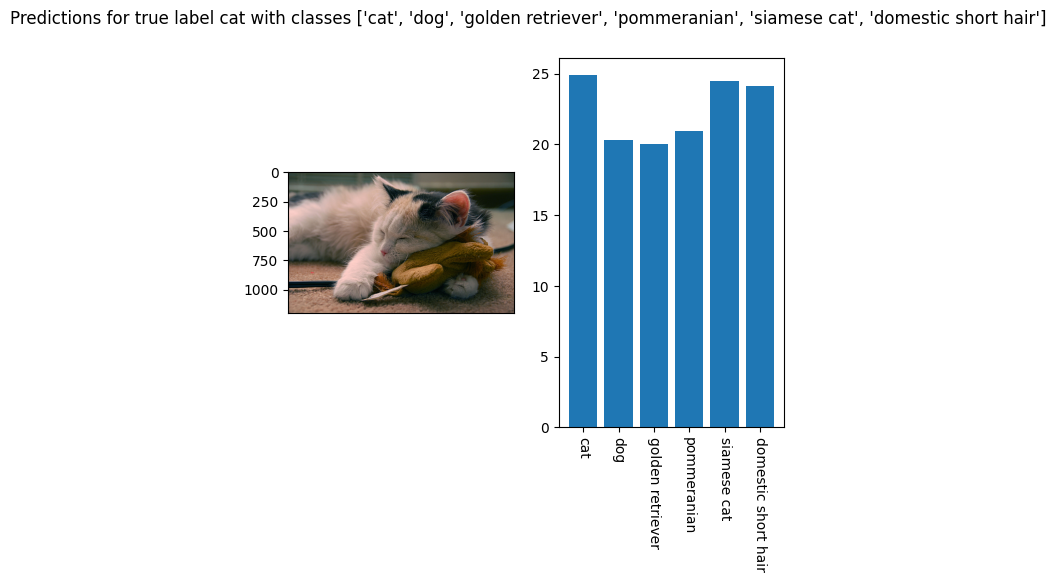

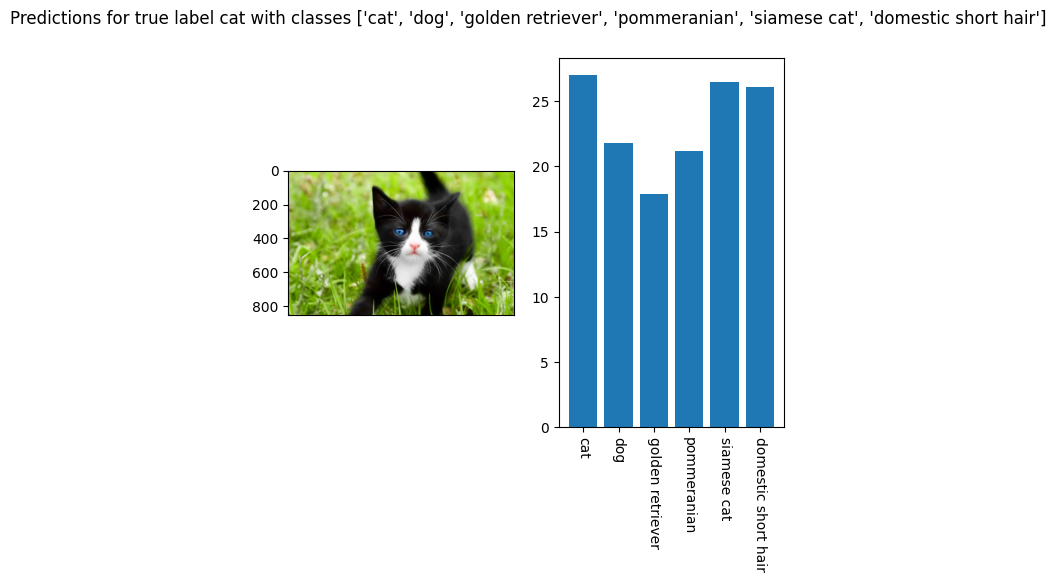

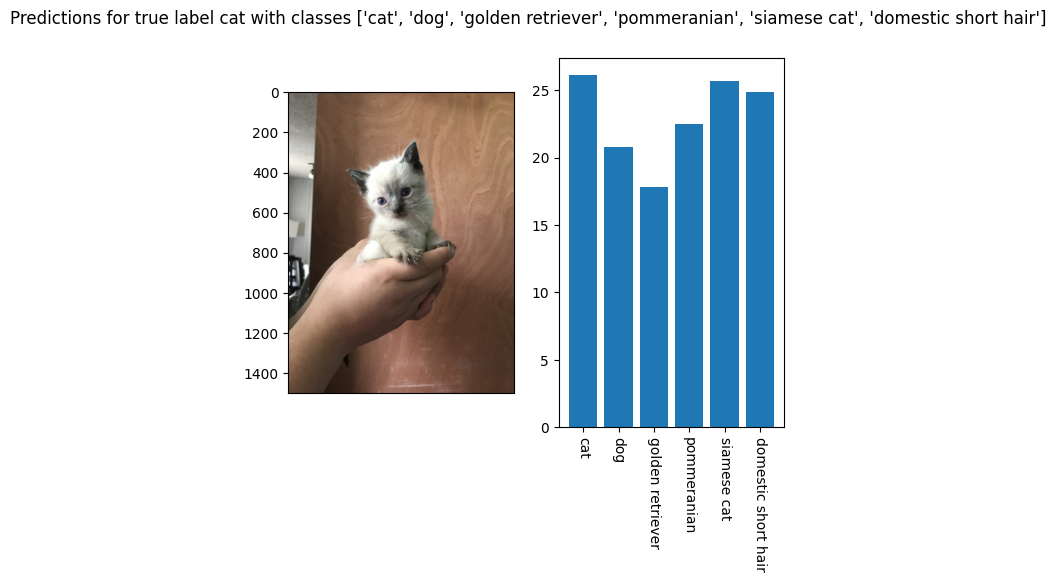

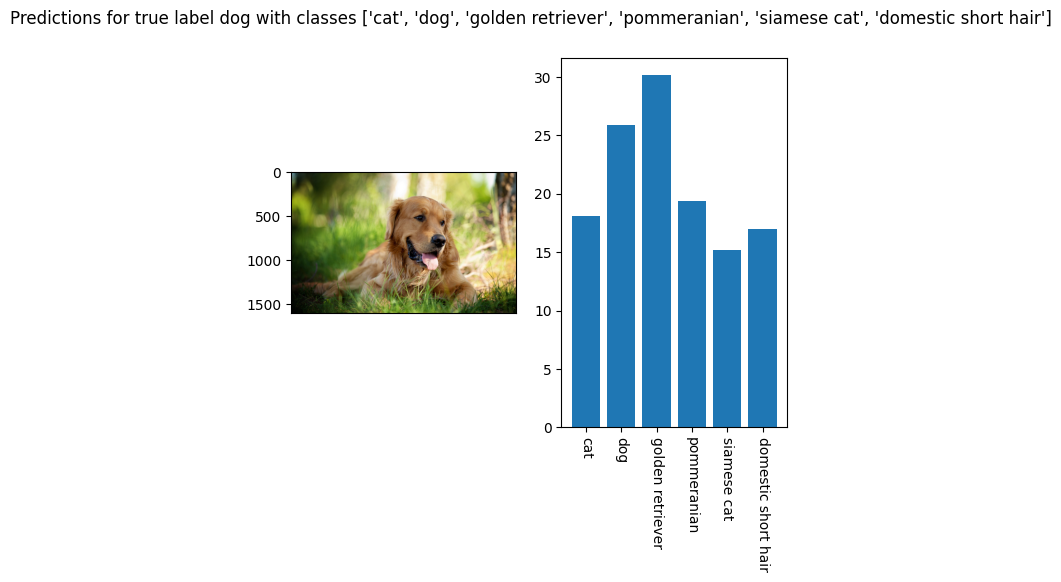

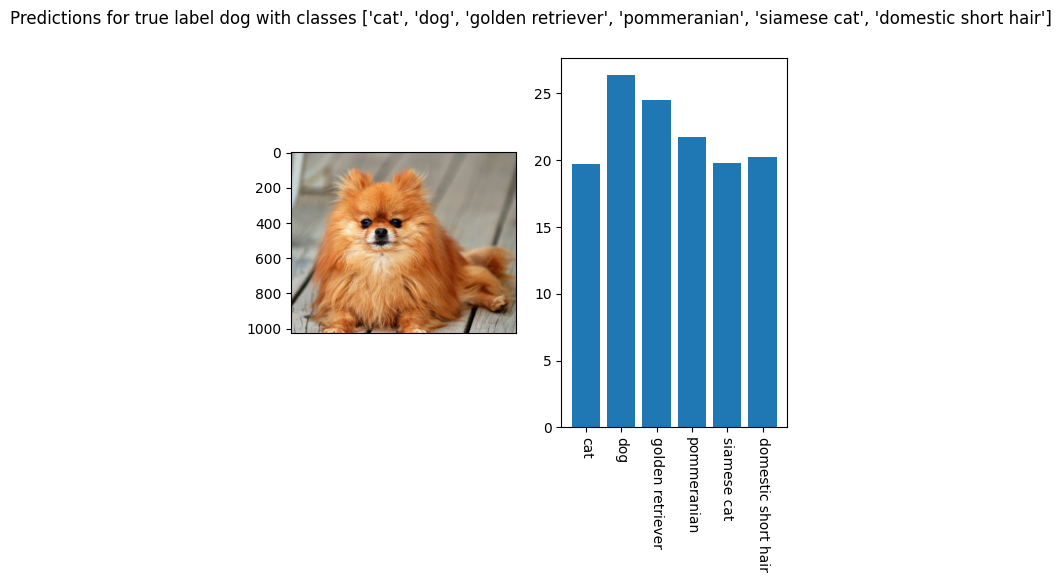

In [9]:
for item in loader:
    img, label = item
    specific_preds = make_preds(img, categories + specific_categories)
    show_results(img, label, specific_preds, categories + specific_categories)

#### Notes:
* Cat/dog alignment across sub categories is still 100% accurate
* CLIP thinks that the Siamese kitten is pretty similar to a pommeranian - this is interesting...
* CLIP thinks that the pommeranian is more similar to a golden retriever than a pommeranian - potentially finding a boundary to the model's understandings

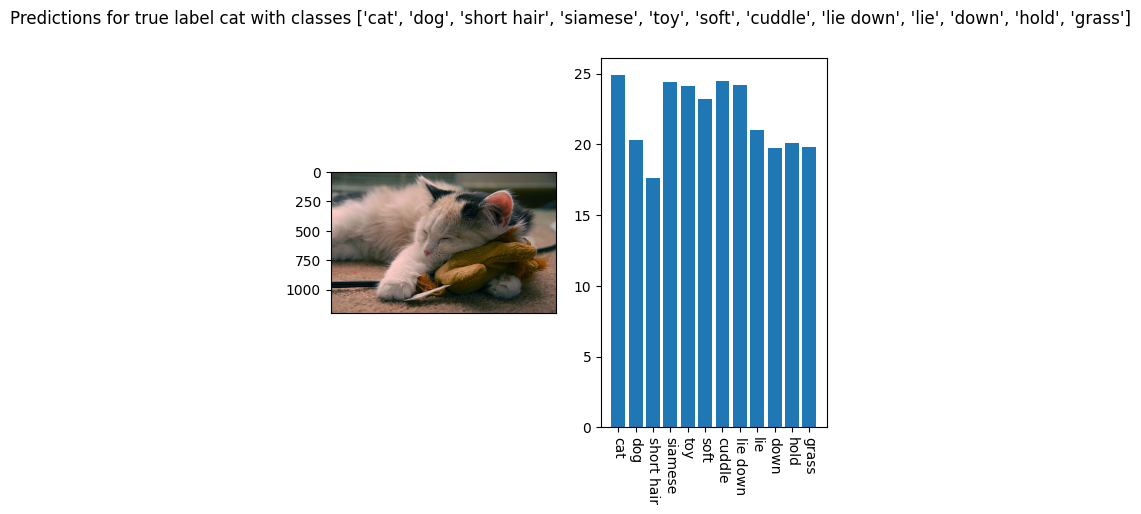

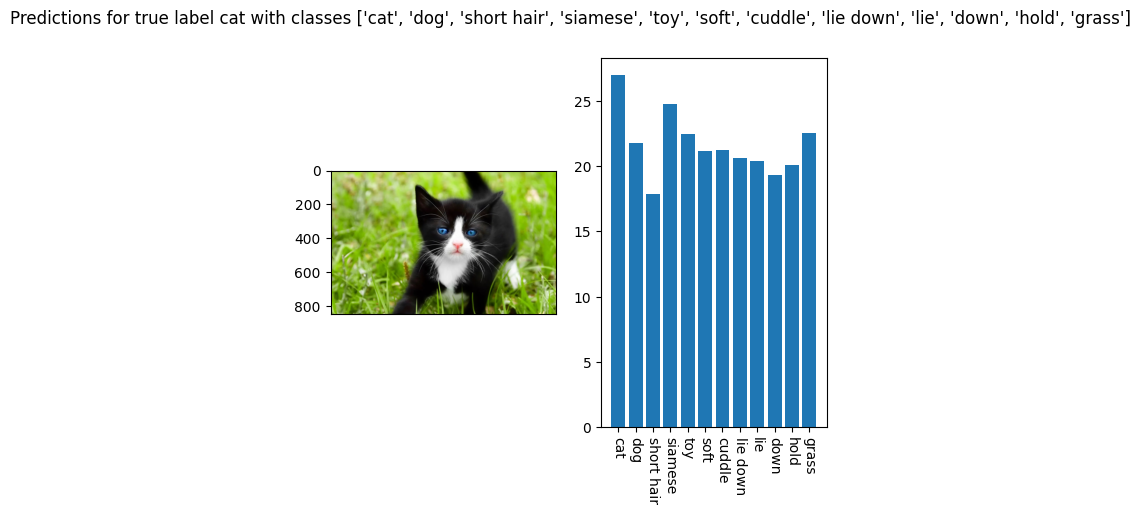

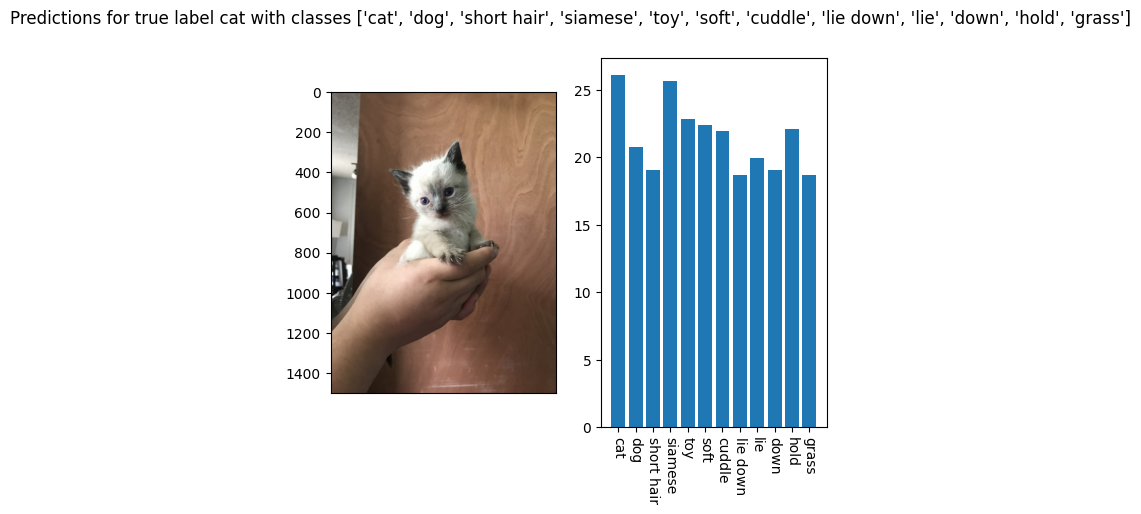

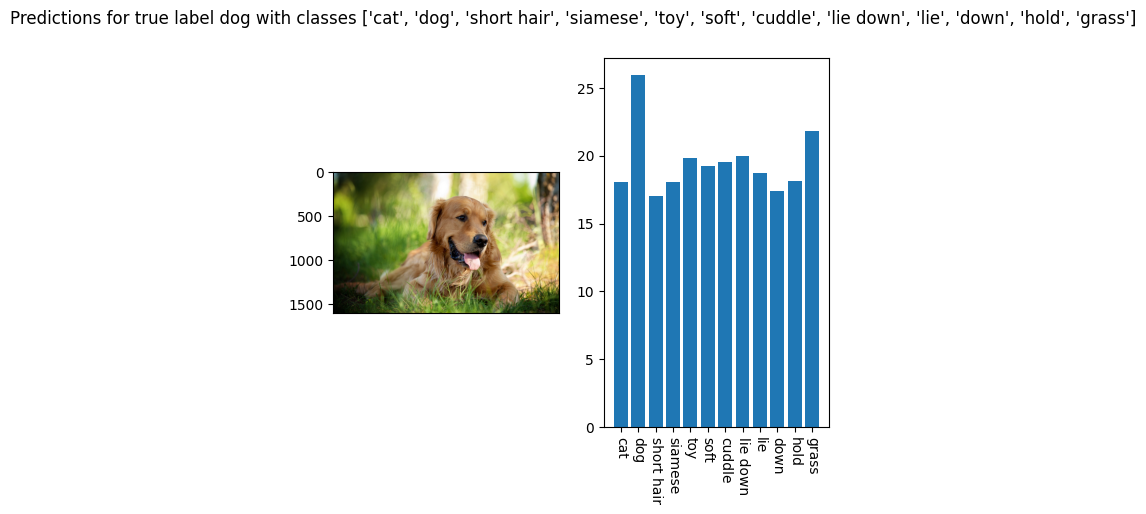

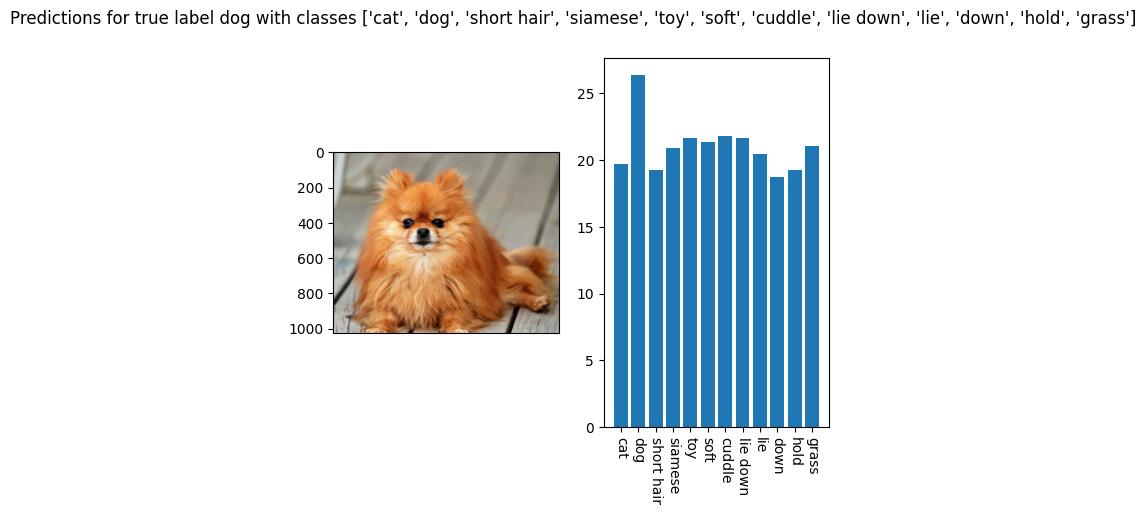

In [10]:
for item in loader:
    img, label = item
    confusing_preds = make_preds(img, categories + confusing_categories)
    show_results(img, label, confusing_preds, categories + confusing_categories)

#### Notes:
* First cat - `toy` ranks nearly as high as `siamese` (Interesting as this is not a Siamese cat)
* `lie down` ranks highly for the first (cat) image, but not for either of the dog images - strict interpretation of this meaning?
  * Separating this into `lie` and `down` leads to the sub-categories being ranked lower than `lie down`
* Not much else of note?

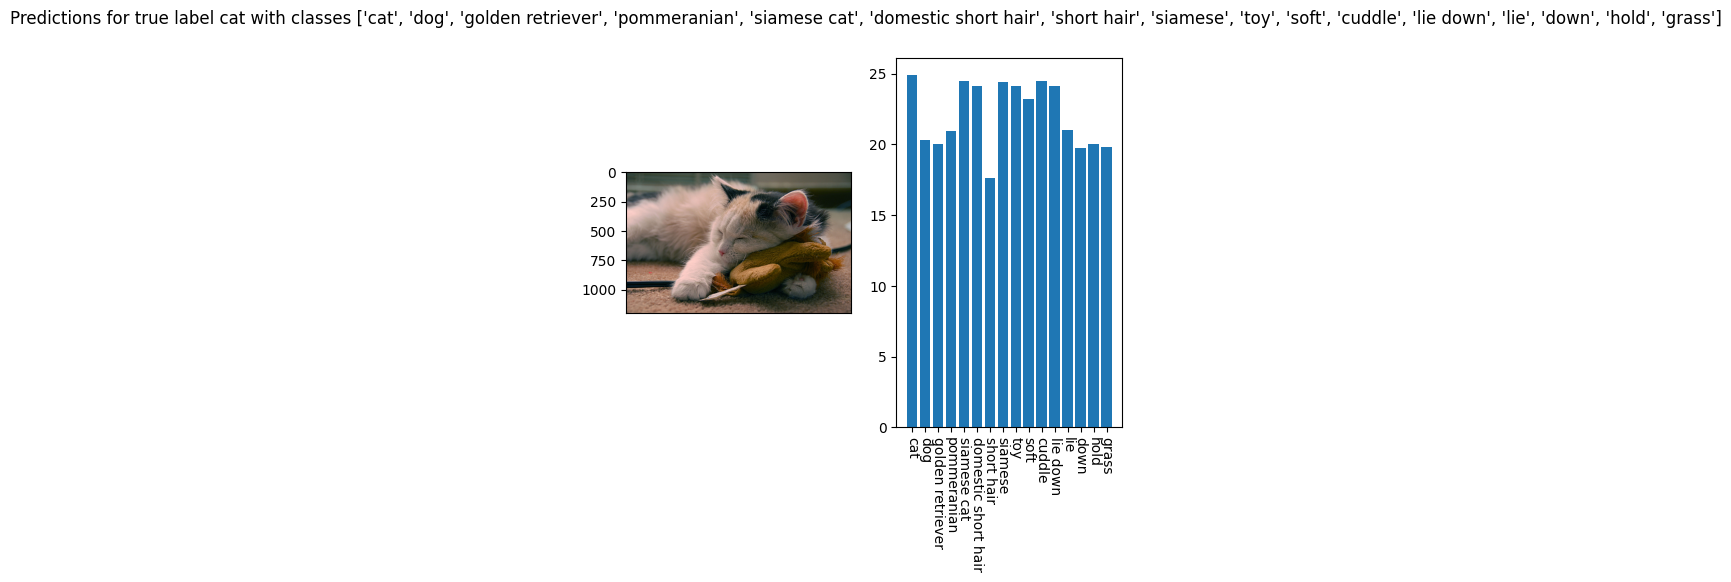

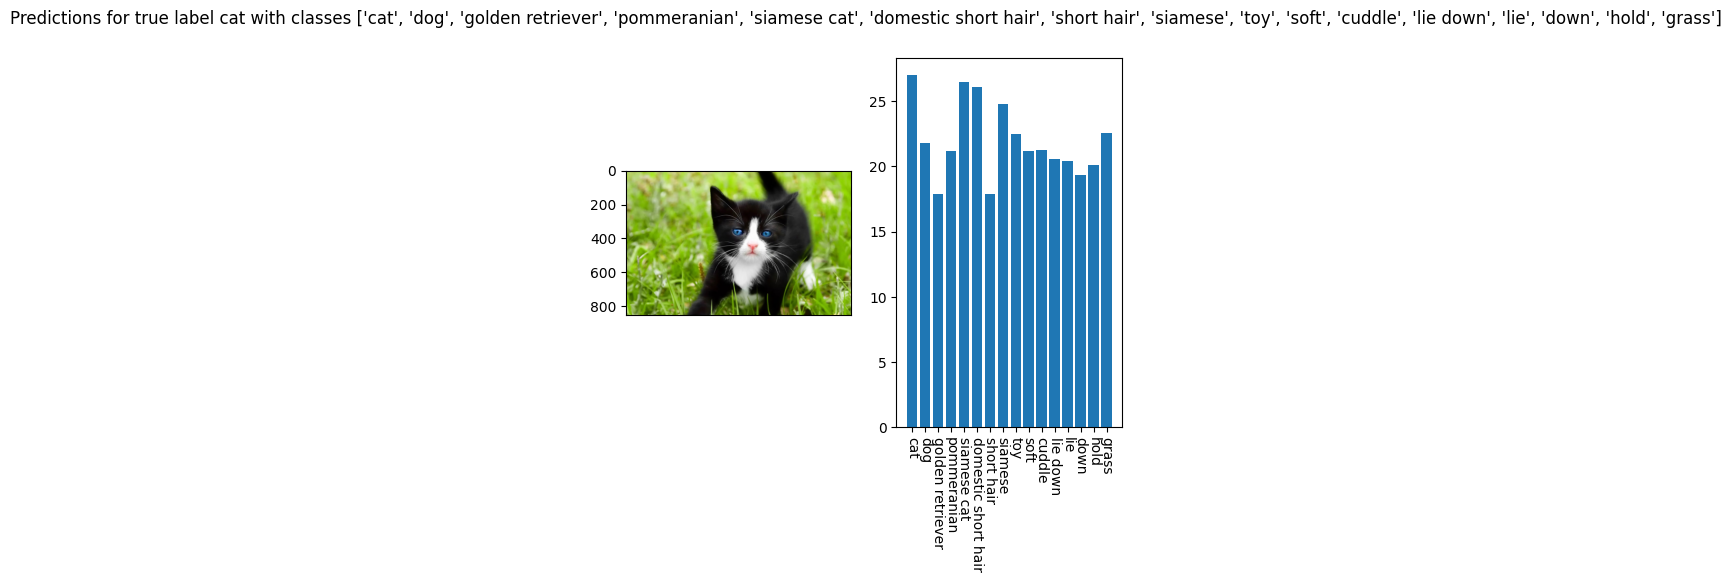

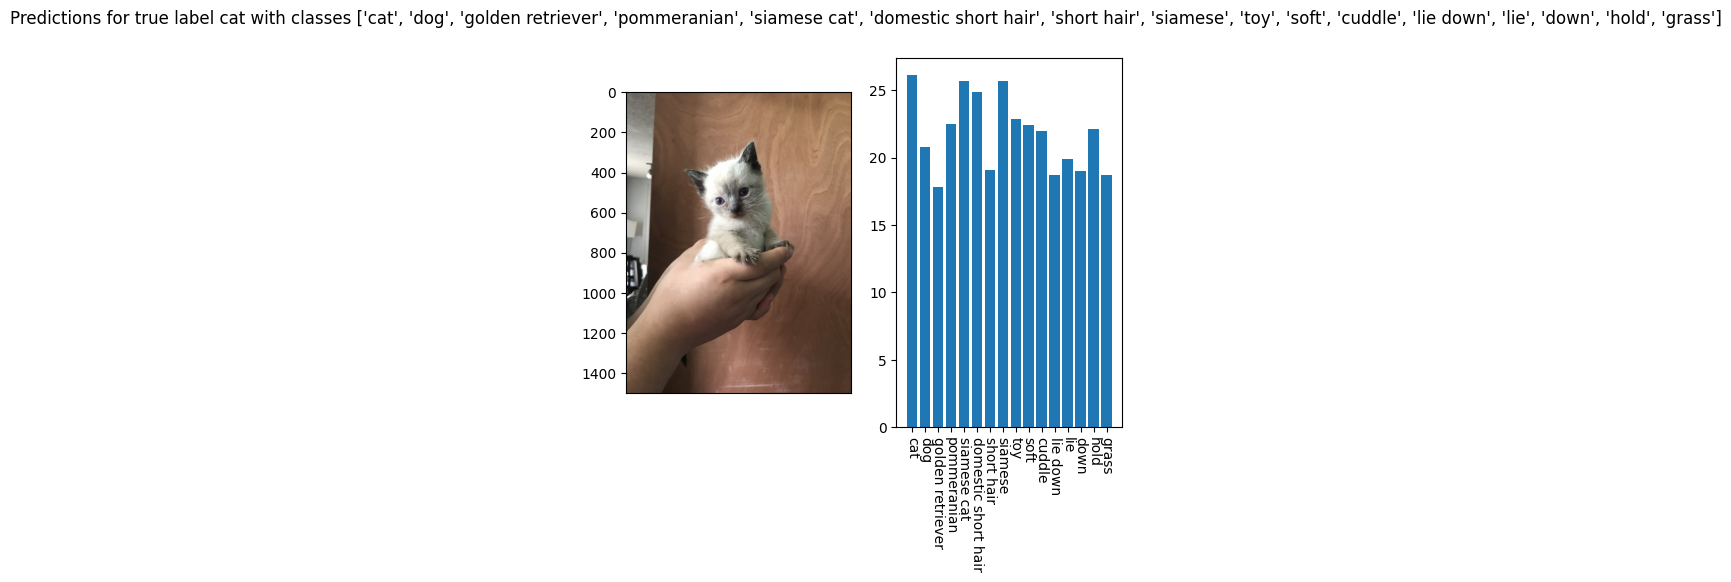

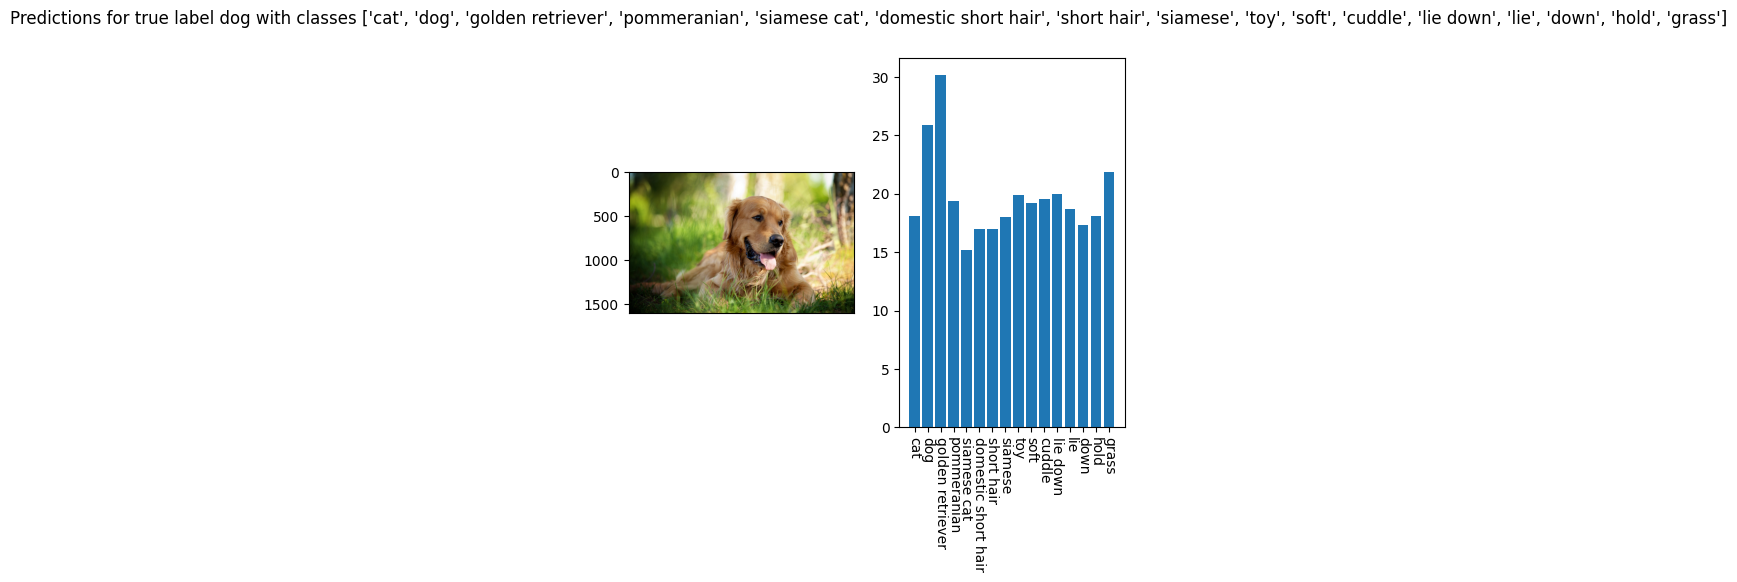

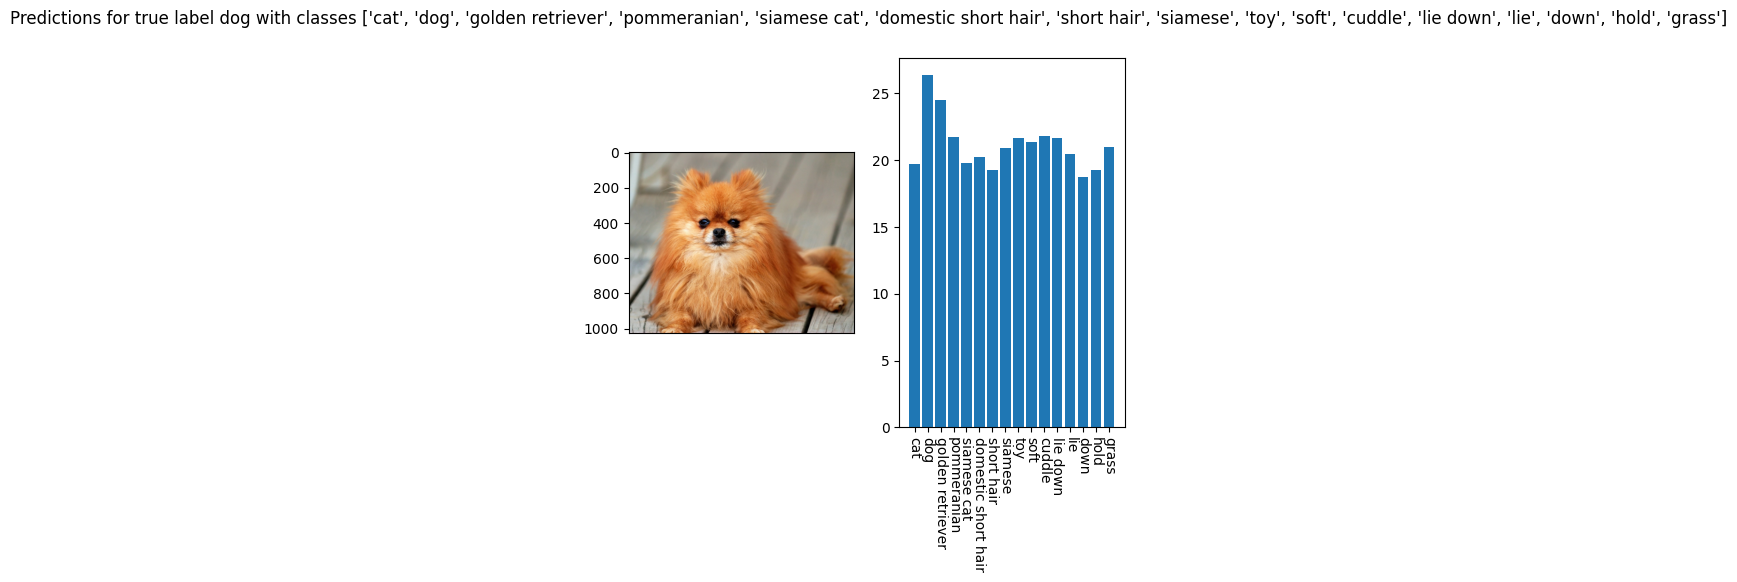

In [11]:
for item in loader:
    img, label = item
    everything_preds = make_preds(img, categories + specific_categories + confusing_categories)
    show_results(img, label, everything_preds, categories + specific_categories + confusing_categories)

#### Notes:
* Dog images have predictions focused around 2 classes, cat images are more spread out
* Probably due to my bias and the rest of what's contained in the images
  * The selected dog images tend to have less in the background/going on

## Chihuahua vs muffin
See if the model can differentiate between them. Include some other categories for a bit more understanding/fun, eg:
* Dog
* Blueberry
* Blueberry muffin
* Cat
* Baked good
* Baked
* Patty pan

In [12]:
base_categories = ["chihuahua", "muffin"]
test_categories = ["dog", "muffin"]
plural_dogs_categories = ["dog", "dogs", "muffin"]
confusing_categories = [
    "dog",
    "blueberry",
    "blueberry muffin",
    "cat",
    "baked",
    "baked good",
    "patty pan",
]

In [13]:
dataset = ImageClassificationDataset("./data/chihuahua_or_muffin")
loader = torch.utils.data.DataLoader(dataset)

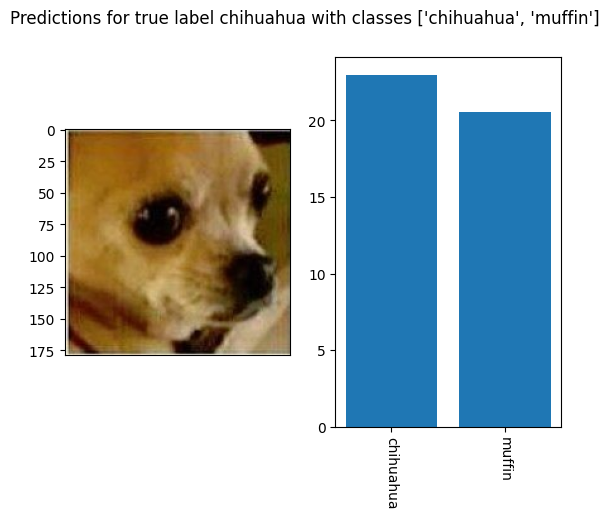

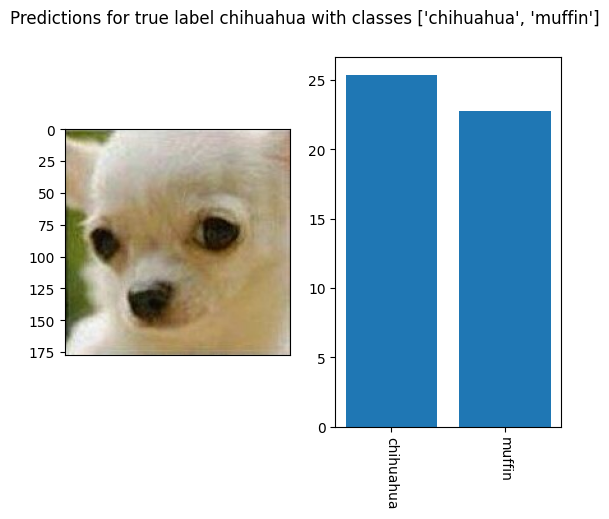

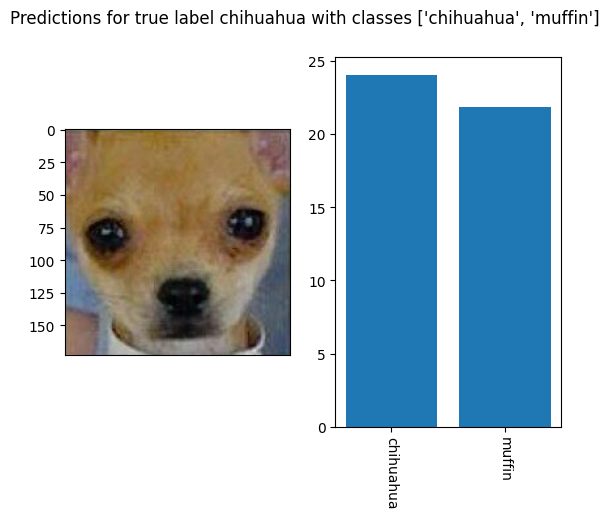

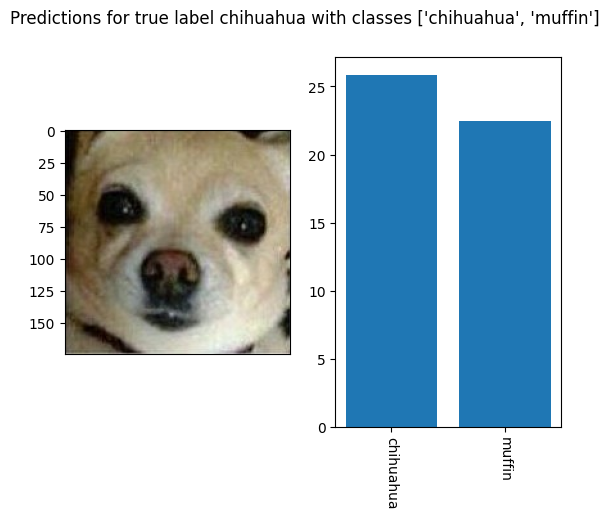

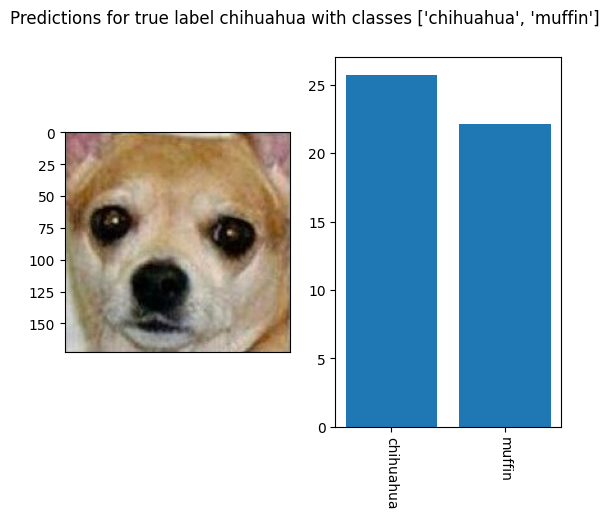

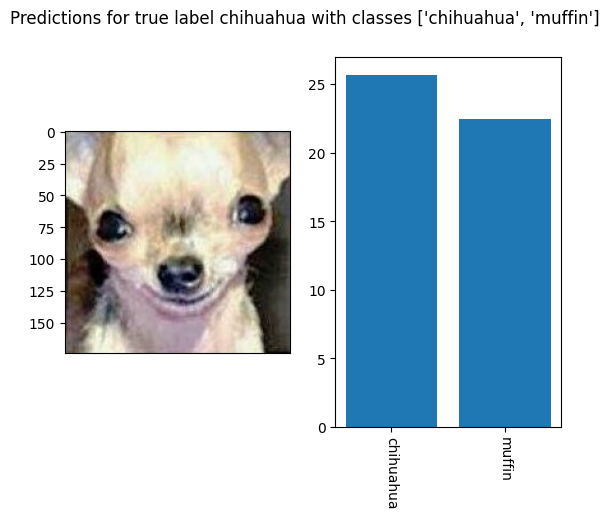

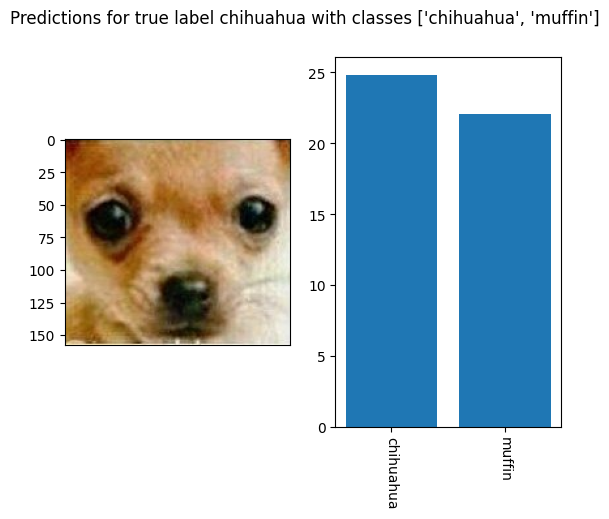

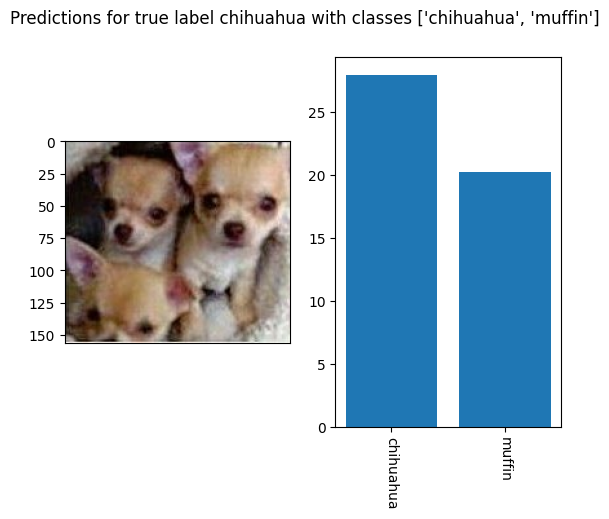

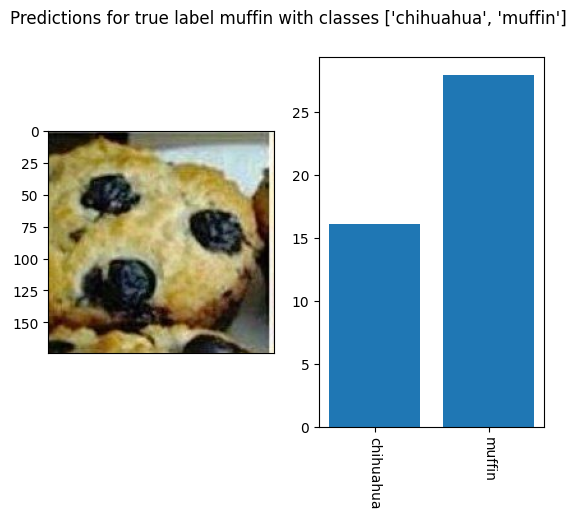

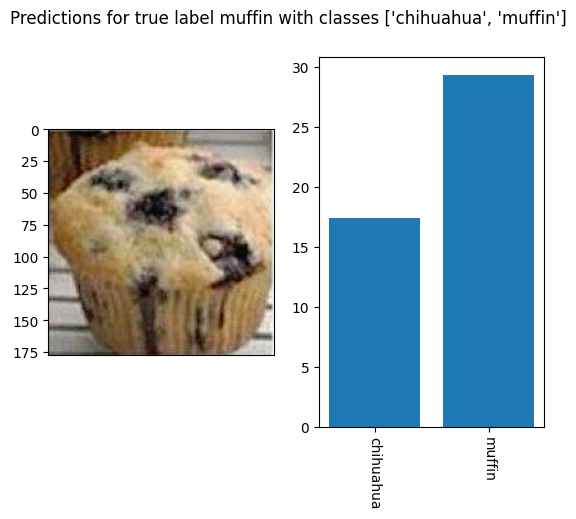

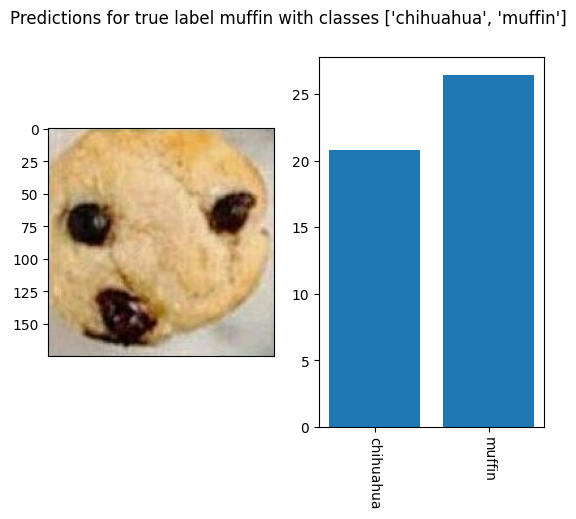

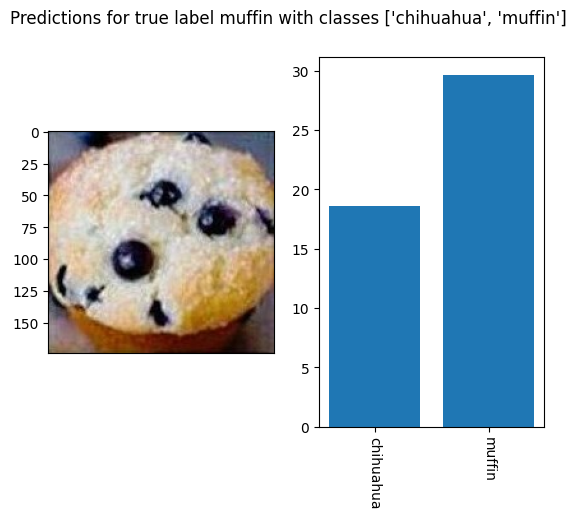

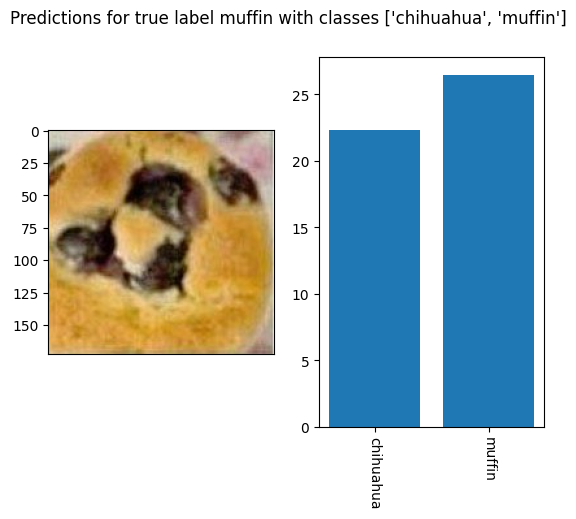

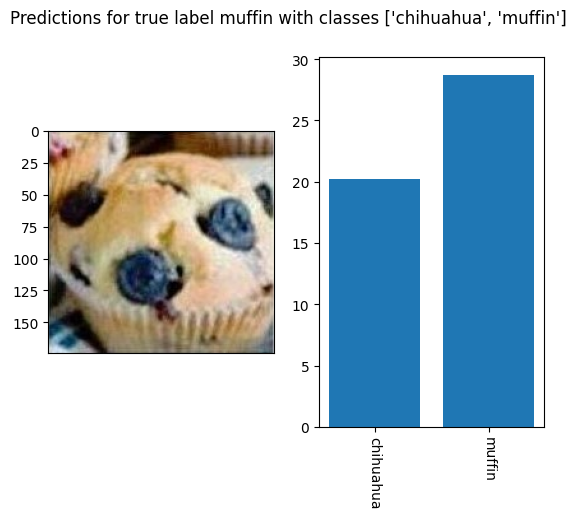

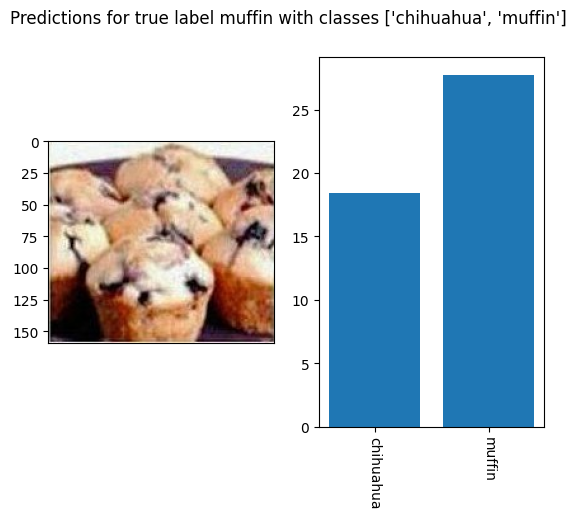

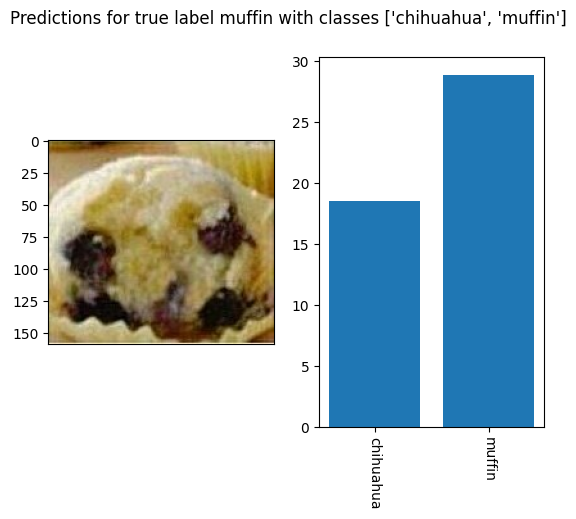

In [14]:
for item in loader:
    img, label = item
    muffin_dog_preds = make_preds(img, base_categories)
    show_results(img, label, muffin_dog_preds, base_categories)

#### Notes:
* I'm amazed how well the model performs on this task
* Generally more confused on the images of the chihuahuas though - try differentiating bewteen dog and muffin?
  * Guessing that:
    * This will make it more confused on the muffins as it's less specific about the kind of dog it's trying to find
    * This will make it less confused by the dogs as there should be more "distance" between the category embeddings (maybe I'm biased by the meme though)
        * Question - what are the embeddings of each category? Which pairs are closer/further aweay?

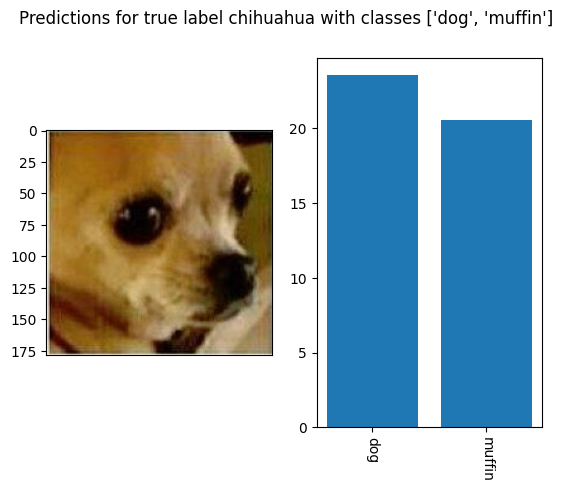

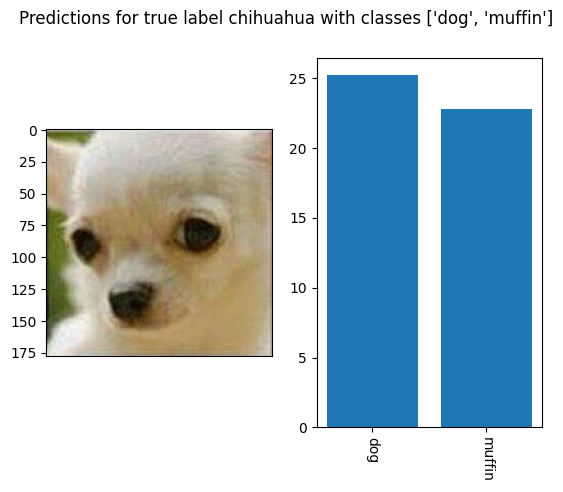

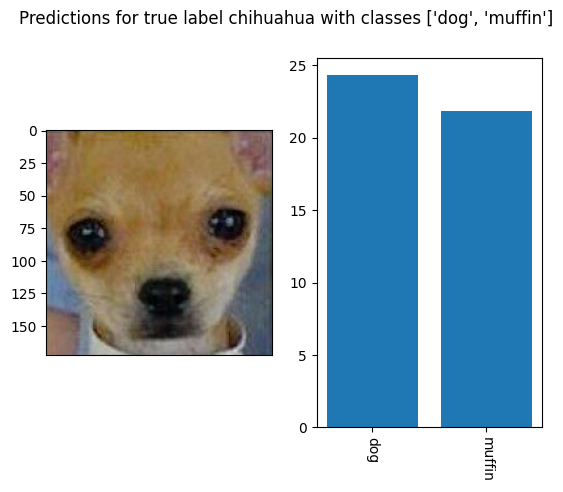

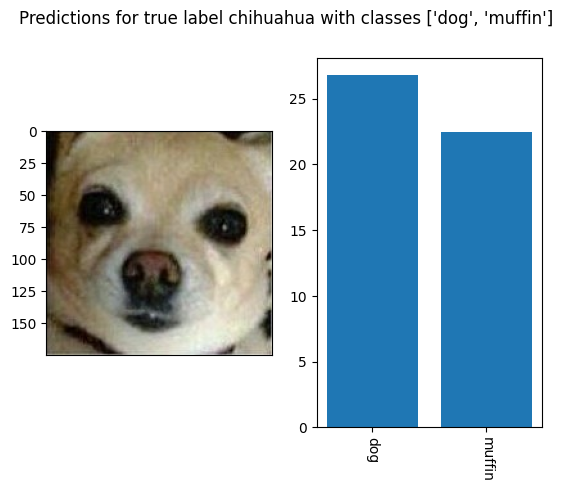

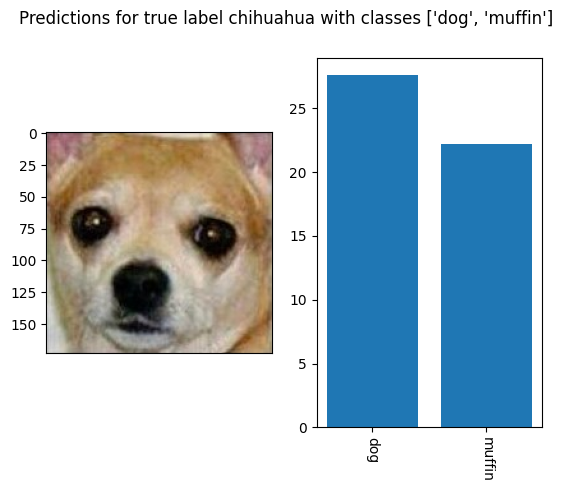

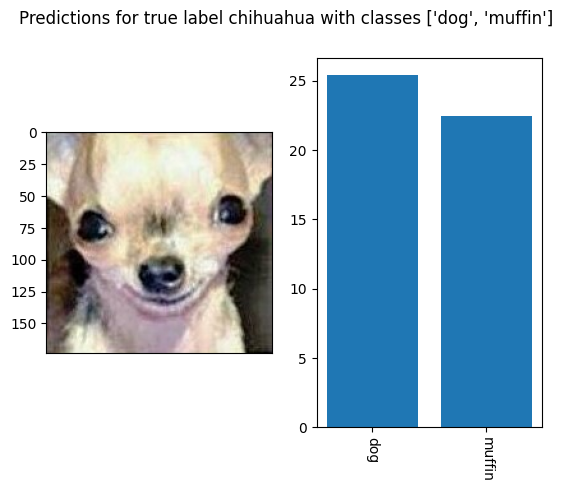

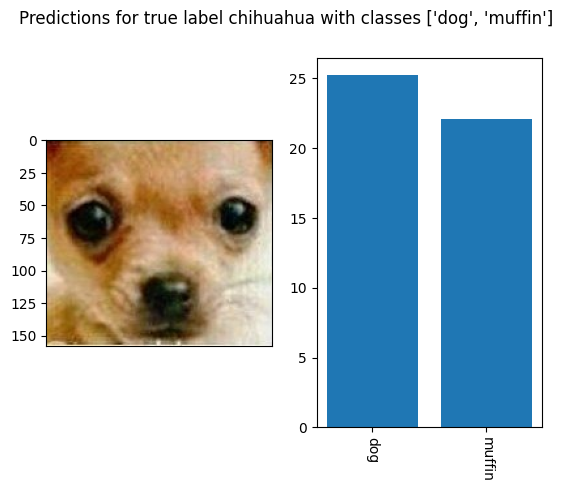

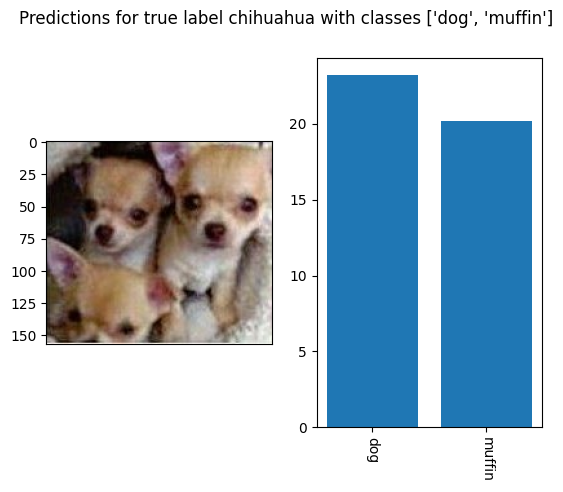

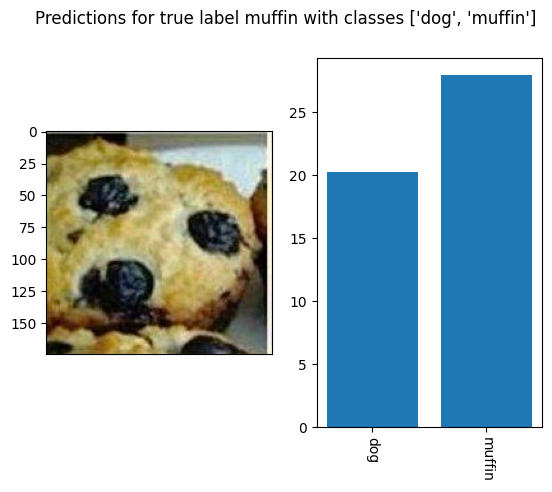

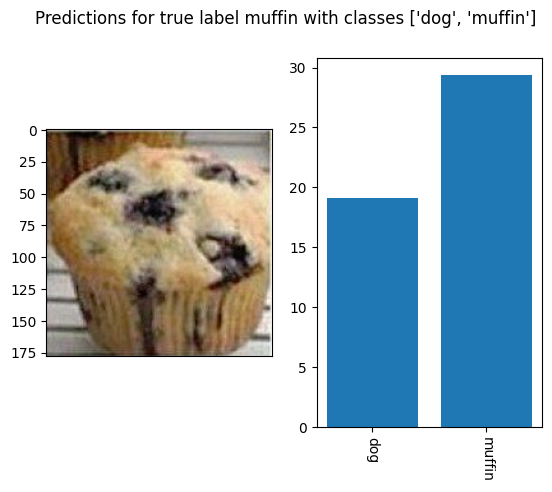

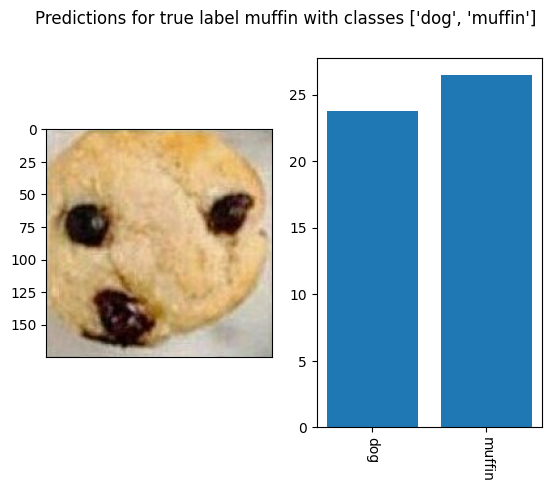

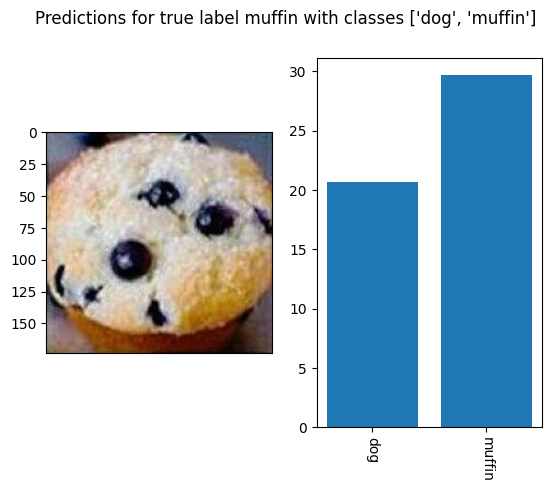

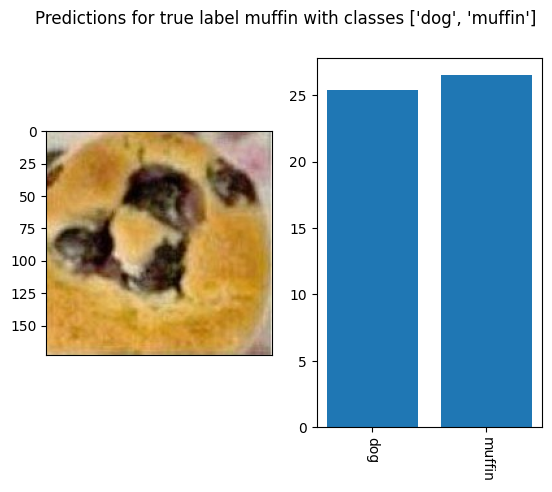

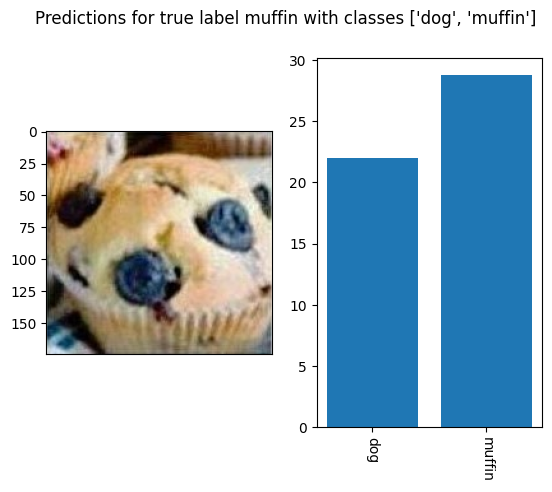

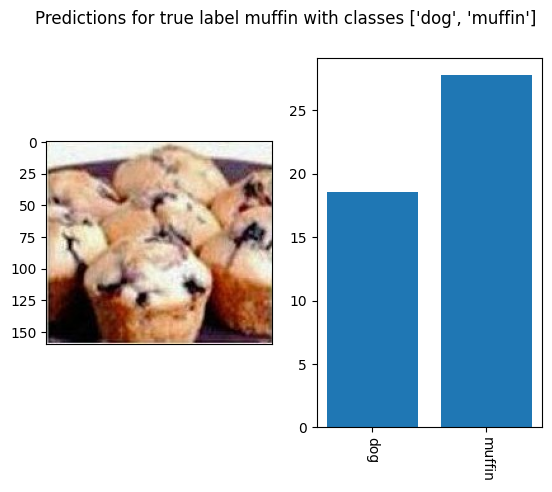

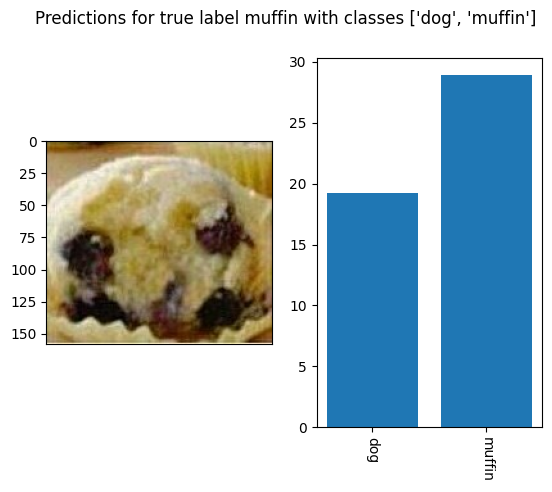

In [15]:
for item in loader:
    img, label = item
    muffin_dog_preds = make_preds(img, test_categories)
    show_results(img, label, muffin_dog_preds, test_categories)

#### Notes:
* Still 100% accurate
* Now is more confused on the muffins
* Confusion hasn't really changed on the dogs - except for the image with multiple chihuahuas
  * Does adding `dogs` as a category make it less confused?

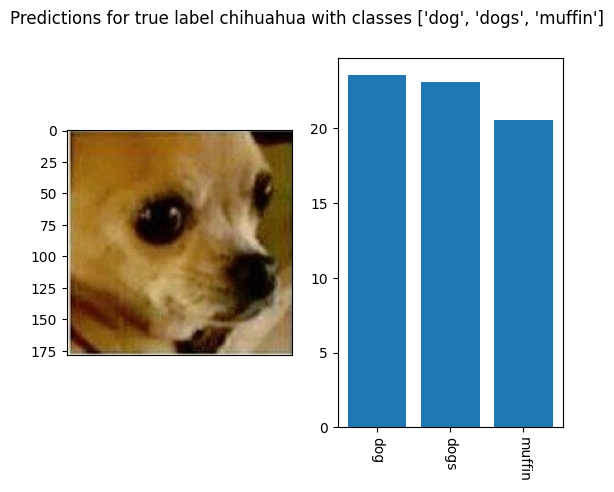

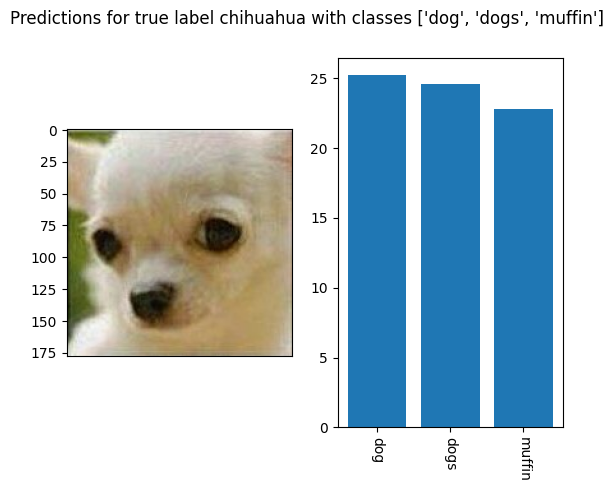

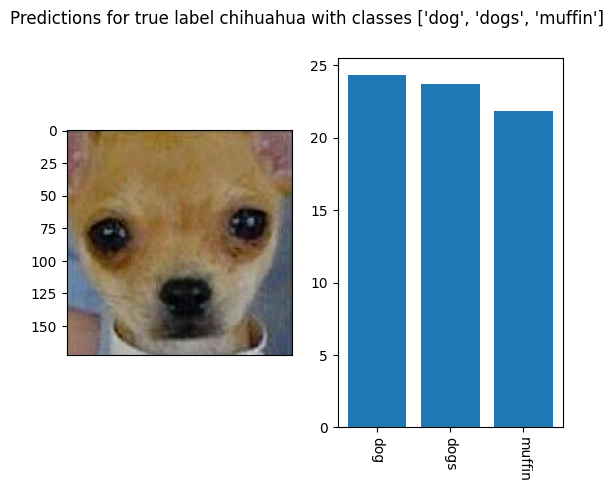

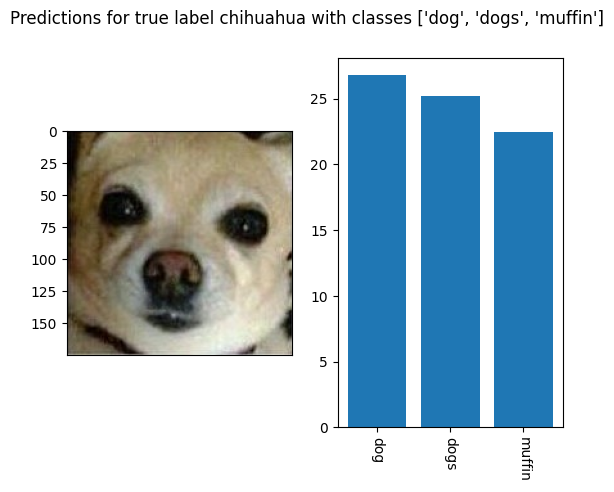

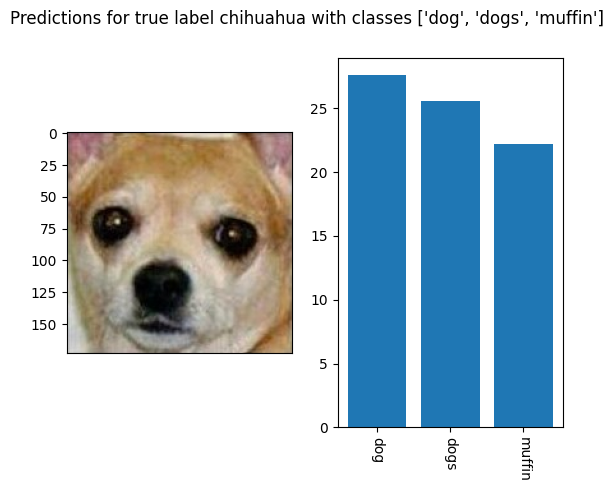

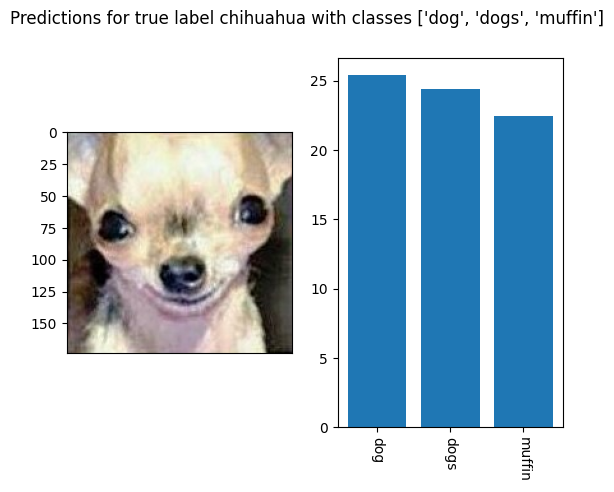

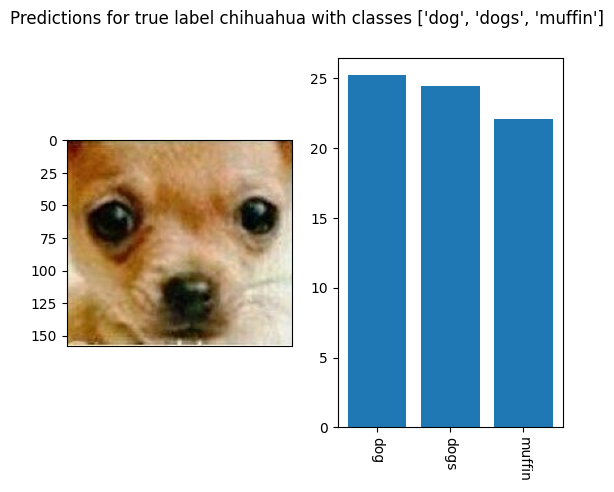

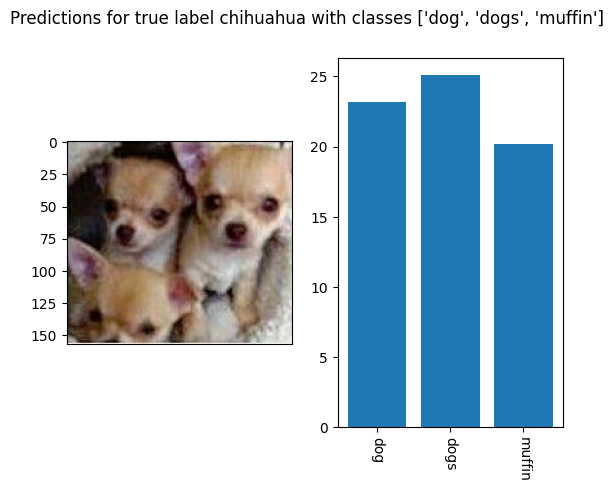

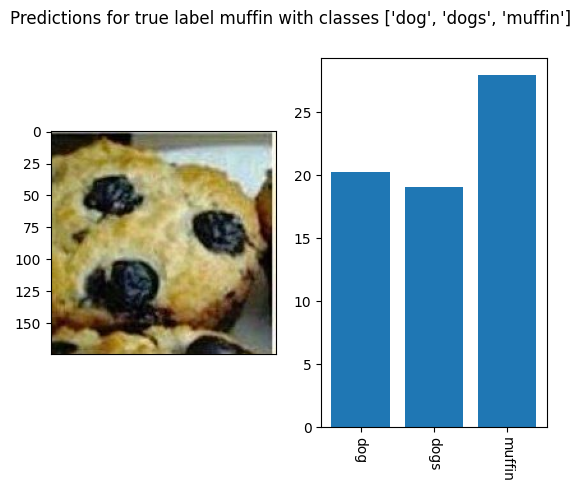

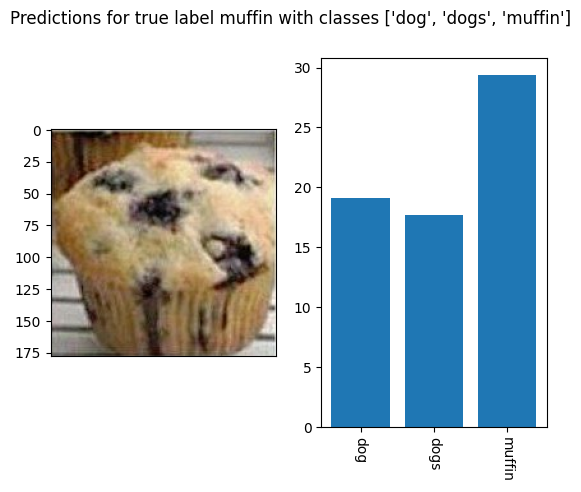

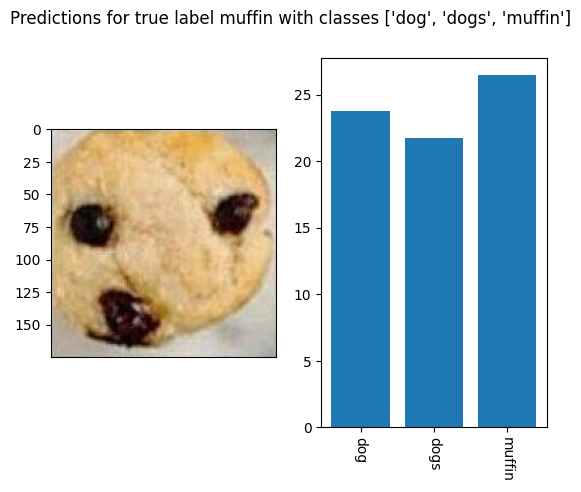

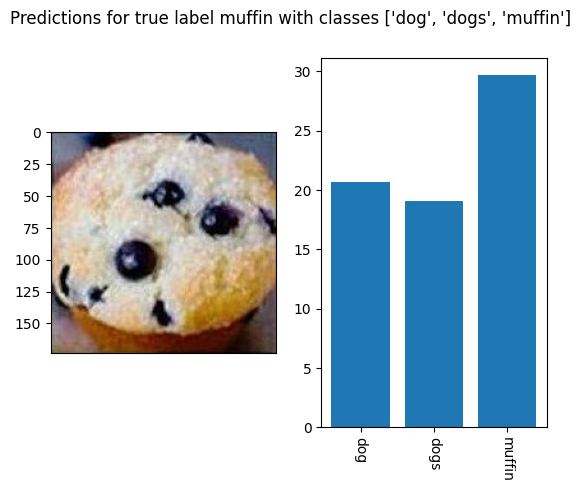

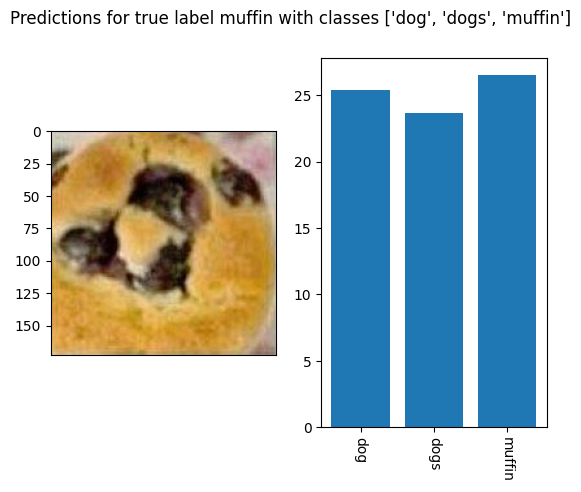

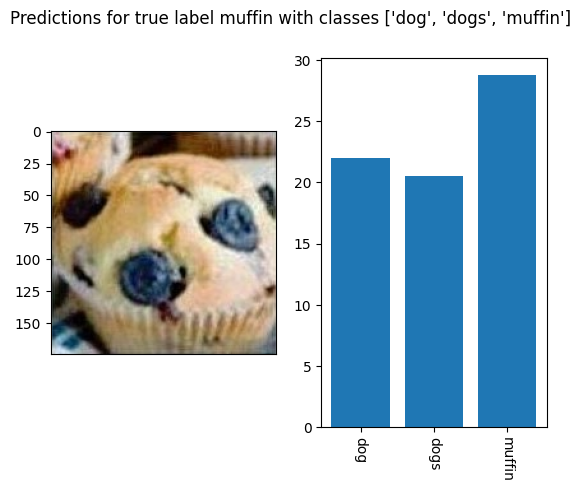

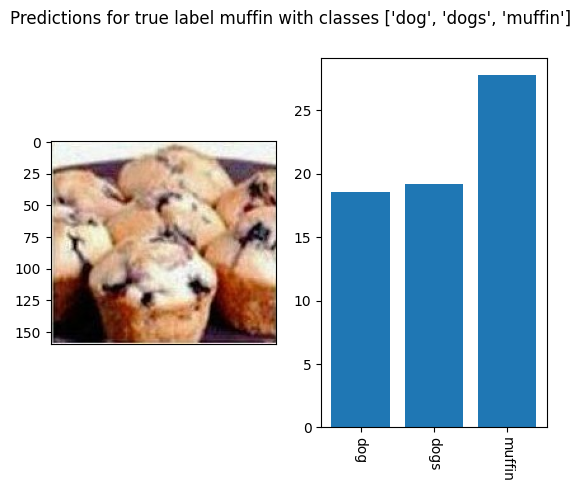

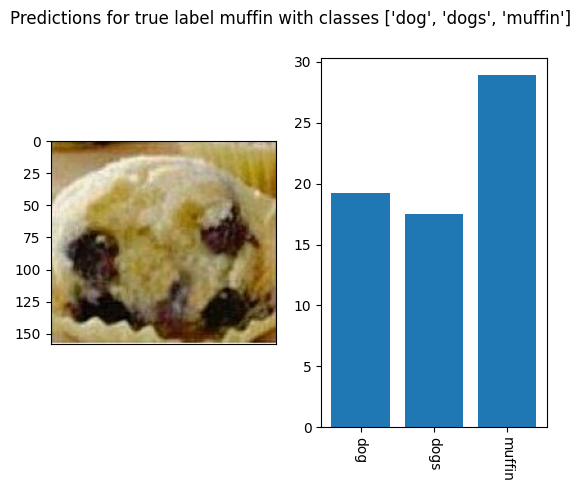

In [16]:
for item in loader:
    img, label = item
    muffin_dog_preds = make_preds(img, plural_dogs_categories)
    show_results(img, label, muffin_dog_preds, plural_dogs_categories)

#### Notes:
* The model appears to understand plurality (yay!)
  * So it does fix the issues seen above
  * But only just, as there's not a huge difference between `dog` and `dogs` in any of these examples

# Retrieval tasks

Some quick ideas of what we could look at:
* Find the minimal prompt that gets the right image
* Prompt with the most superfluous info that gets the right image
* How little can you add to the prompt to get it to return the wrong image?
  * Using only valid words, considering 2 cases:
    * With context that makes sense
    * Allowing for semi-gibberish

I have seen [this notebook](https://colab.research.google.com/drive/1bLVwVKpAndpEDHqjzxVPr_9nGrSbuOQd?usp=sharing#scrollTo=yjzAn82VvIzn), but want to implement this with as little reference to this as possible

##  Chihuahua or muffin

Potential prompts:
* "Get me a chihuahua"
* "Show me a chihuahua that looks like a muffin"
* "A muffin that looks like a chihuahua"

## Receipt based on contents

Can the model:
* Determine the contents of a receipt?
* Retrieve the correct receipt based on a description of what was sold?
* Retrieve a receipt based on the total?
  * Or the price of one of the purchased items? 